Goal:

build a CNN using Transfer Learning to predict correct classification for a road sign

#### Libraries

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns 

In [ ]:
from numpy.random import seed
seed(1337) # for recreating results

In [ ]:
import tensorflow
tensorflow.random.set_seed(42)

from tensorflow.python.keras.applications import vgg16
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import layers, models, Model # , optimizers
from tensorflow.keras import optimizers

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # performance metrics

#### Kaggle API

1. create API key in Kaggle 
2. open folder on LHS, go up to root folder
3. drag and drop kaggle.json into root folder
4. run cells below

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/root"

In [ ]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 610M/612M [00:05<00:00, 148MB/s]
100% 612M/612M [00:05<00:00, 122MB/s]


In [ ]:
!unzip /content/gtsrb-german-traffic-sign.zip -d review

#### EDA

##### Connect to training and test data

In [ ]:
train_data_dir = "/content/review/train"
test_data_dir = "/content/review/test"

Text(0.5, 1.0, 'Number of training images per category:')

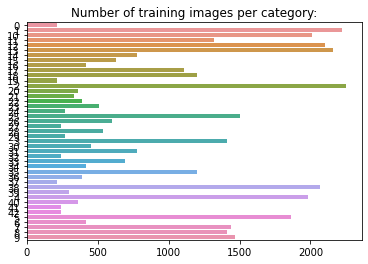

In [ ]:
# plot our training data image distribution

category_names = sorted(os.listdir(train_data_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = train_data_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

we have too many categories above, so we will use a subset for training purposes

In [ ]:
# Exercise - check number of images in the training and test set


43

In [ ]:
len(os.listdir(test_data_dir)) # no of files in the test directory

12631

In [ ]:
#mapping for 10 specific signs
signs = ["Bikes","Forbidden_for_traffic", "Intersection", "No_entry", "Pedestrians", "Right_of_way", "Slippery_road", "Speed_60", "Stop", "Yield"]

signNrs = ["29","15", "11", "17", "27", "12", "23", "3", "14", "13"]

# 29 "Bikes"
# 15 Forbidden_for_traffic
# 11 Intersection
# 17 No_entry
# 27 Pedestrians
# 12 Right_of_way
# 23 Slippery_road
# 3 Speed_60
# 14 Stop
# 13 Yield

Text(0.5, 1.0, 'Number of training images per category:')

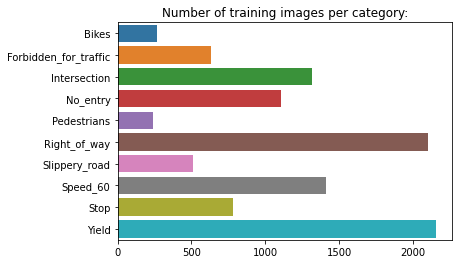

In [ ]:
# do a plot just for 10 categories above

category_names = signs
nb_categories = len(category_names)
img_pr_cat = []
for category in signNrs:
    folder = train_data_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

dataset is TOO imbalanced, so lets just take 200 random images from each of the 10 folders above

In [ ]:
# Exercise - add code to put 200 random images into a new folder structure



In [ ]:
# Exercise - have a go at replicating the above for a smaller (100 image) test and 
# validation folder

In [ ]:
testShort = "/content/review/test-short"

nr_images = 100

# error handler to check if folder exists and remove it first before re-running this cell / recreating the folder
try:
    shutil.rmtree(testShort) # removes directory
except:
    pass

for i in range (0,10):
    
    dirpath = os.path.join(train_data_dir, signNrs[i])
    # NB below is for creating a test folder, first time this is run, would need to do for train, validate and test sets

    destDirectory = os.path.join(testShort , signs[i])
    
    try:
        os.makedirs(destDirectory)
    except FileExistsError:
        # directory already exists
        pass
    
    filenames = random.sample(os.listdir(dirpath), nr_images)
    
    for fname in filenames:
        srcpath = os.path.join(dirpath, fname)
        destpath = os.path.join(destDirectory, fname)
        shutil.copyfile(srcpath, destpath)

In [ ]:
valShort = "/content/review/val-short"

nr_images = 100

# add an error handler to check if folder exists and remove it first before re-running this cell / recreating the folder
try:
    shutil.rmtree(valShort) # removes directory
except:
    pass

for i in range (0,10):
    
    dirpath = os.path.join(train_data_dir, signNrs[i])
    # NB below is for creating a test folder, first time this is run, would need to do for train, validate and test sets

    destDirectory = os.path.join(valShort , signs[i])
    
    try:
        os.makedirs(destDirectory)
    except FileExistsError:
        # directory already exists
        pass
    
    filenames = random.sample(os.listdir(dirpath), nr_images)
    
    for fname in filenames:
        srcpath = os.path.join(dirpath, fname)
        destpath = os.path.join(destDirectory, fname)
        shutil.copyfile(srcpath, destpath)

##### Check our subset of images

Text(0.5, 1.0, 'Number of training images per category:')

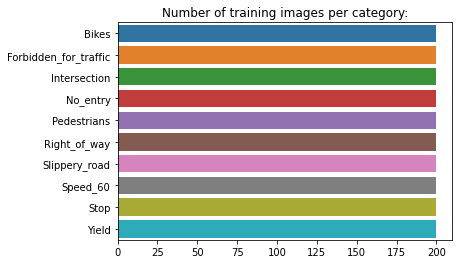

In [ ]:
# do a plot just for 10 categories above

category_names = signs
nb_categories = len(category_names)
img_pr_cat = []
for category in signs:
    folder = trainShort + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

#### Model Prep

###### Converting images into numpy arrays

In [ ]:
import cv2 # Computer Vision library for python

train_width=[]
test_width=[]
cv_width=[]
count=0

for category in category_names: 
  print("train " + category ) # update user at what stage we are at
  folder = trainShort + '/' + category
  for image in os.listdir(trainShort + '/' + category):
          im = cv2.imread(folder + '/' + image,cv2.IMREAD_GRAYSCALE)
          train_width.append(im.shape[1])
        

  print("test "+ category ) # update user at what stage we are at  
  folder = testShort+ '/' + category
  for image in os.listdir(testShort + '/' + category):
          im = cv2.imread(folder + '/' + image,cv2.IMREAD_GRAYSCALE)
          test_width.append(im.shape[1])
          
  print("val "+ category) # update user at what stage we are at
  folder = valShort+ '/' + category 
  for image in os.listdir(valShort + '/' + category):
          im = cv2.imread(folder + '/' + image,cv2.IMREAD_GRAYSCALE)
          cv_width.append(im.shape[1])

train Bikes
test Bikes
val Bikes
train Forbidden_for_traffic
test Forbidden_for_traffic
val Forbidden_for_traffic
train Intersection
test Intersection
val Intersection
train No_entry
test No_entry
val No_entry
train Pedestrians
test Pedestrians
val Pedestrians
train Right_of_way
test Right_of_way
val Right_of_way
train Slippery_road
test Slippery_road
val Slippery_road
train Speed_60
test Speed_60
val Speed_60
train Stop
test Stop
val Stop
train Yield
test Yield
val Yield


In [ ]:
# check - quick peek at how the image data is converted using Computer Vision
cv2.imread(folder + '/' + image,cv2.IMREAD_GRAYSCALE)

array([[115,  94, 124, ..., 255, 251, 248],
       [114,  96, 131, ..., 255, 251, 248],
       [ 97,  98, 147, ..., 254, 251, 248],
       ...,
       [ 82,  93,  96, ...,  66,  72,  70],
       [ 80,  91,  90, ...,  73,  72,  71],
       [ 79,  83,  85, ...,  73,  72,  72]], dtype=uint8)

##### Plot image widths

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


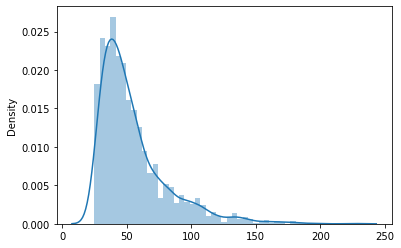

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


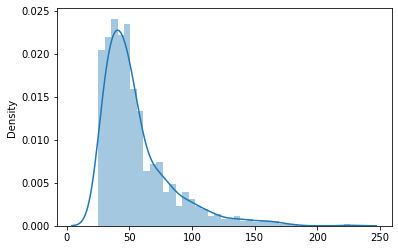

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


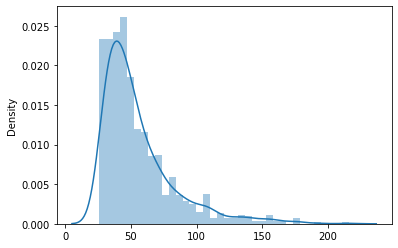

In [ ]:
# show widths of images in each folder

width=(train_width,test_width,cv_width)

for x in width:
  sns.distplot(x,kde = True)
  plt.show()

##### Check image samples

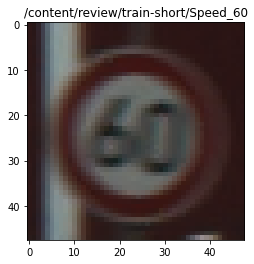

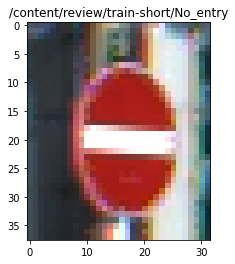

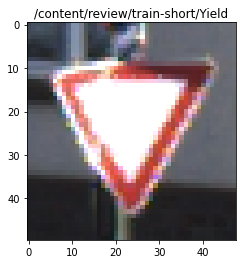

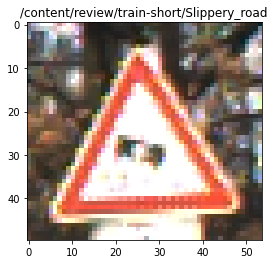

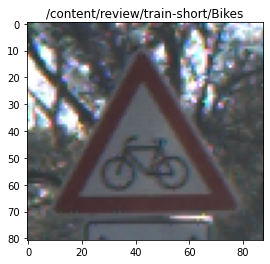

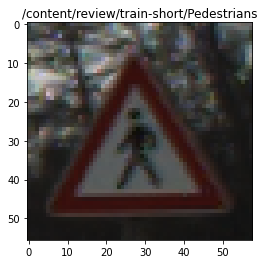

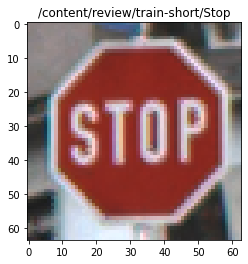

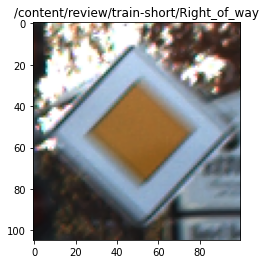

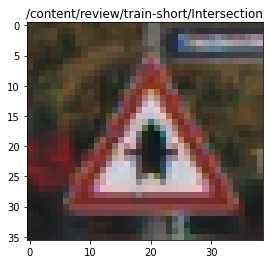

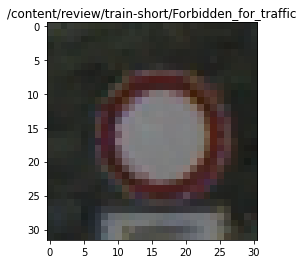

In [ ]:
# show one example image from each classification folder

for subdir, dirs, files in os.walk(trainShort):
    for file in files:
        img_file = subdir + '/' + file
        image = load_img(img_file)
        plt.figure()
        plt.title(subdir)
        plt.imshow(image)
        break

#### Transfer Learning

In [ ]:
img_height, img_width = 224,224
#our convolution "base" is the VGG model - we are using it for "transfer learning"
conv_base = vgg16.VGG16(weights='imagenet', include_top=False, pooling='max', input_shape = (img_width, img_height, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# view the convolutional layers
for layer in conv_base.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f0093933b50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f00918e2210> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f009313f9d0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f0093144ed0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f009101ffd0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f009104bcd0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f009104be10> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f008066b790> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0080676590> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0080676750> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f008066be90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0080685

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(nb_categories,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 10)                5130      
Total params: 14,719,818
Trainable params: 14,719,818
Non-trainable params: 0
_________________________________________________________________


##### Generators for reading and processing images

In [ ]:
#Number of images to load at each iteration

batch_size = 32
# only rescaling
train_datagen =  ImageDataGenerator(
    rescale=1./255
)
test_datagen =  ImageDataGenerator(
    rescale=1./255
)

# these are generators for train/test data that will read pictures #found in the defined subfolders of 'data/'
print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(
trainShort,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

print('Total number of images for "validation":')
val_generator = test_datagen.flow_from_directory(
valShort,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)

print('Total number of images for "testing":')
test_generator = test_datagen.flow_from_directory(
testShort,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)

Total number of images for "training":
Found 2000 images belonging to 10 classes.
Total number of images for "validation":
Found 1000 images belonging to 10 classes.
Total number of images for "testing":
Found 1000 images belonging to 10 classes.


##### Compile & Build Model Baseline


In [ ]:
learning_rate = 5e-5
epochs = 10

checkpoint = ModelCheckpoint("traffic-28jun21.h5", monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq=1)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate, clipnorm = 1.), metrics = ['acc'])

In [ ]:
history = model.fit(train_generator,
                    epochs = epochs,
                    shuffle=True,
                    validation_data=val_generator,
                    callbacks=[checkpoint])

##### Evaluating Model Accuracy

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('Accuracy.jpg')

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('Loss.jpg')

In [ ]:
# Exercise - model looks overfit - re-run using a technique to avoid overfitting

##### 2nd Run - Early Stopping Criteria

In [ ]:
from keras.callbacks import EarlyStopping

learning_rate = 5e-5
epochs = 10

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate, clipnorm = 1.), metrics = ['acc'])

es = EarlyStopping(monitor = "val_loss", mode="min", verbose = 1)
mc = ModelCheckpoint("best-model.h5", monitor = 'val_acc', mode="max", verbose=1, save_best_only=True)


In [ ]:
history = model.fit(train_generator,
                    epochs = epochs,
                    shuffle=True,
                    validation_data=val_generator,
                    callbacks=[es,mc]) # early stopping and checkpint handled by callbacks

Epoch 1/10
63/63 [==============================] - 79s 589ms/step - loss: 0.7874 - acc: 0.7440 - val_loss: 0.0743 - val_acc: 0.9780

Epoch 00001: val_acc improved from -inf to 0.97800, saving model to best-model.h5


##### 2nd Run - Metrics

In [ ]:
#access our "best model" from the last run

from keras.models import load_model
saved_model = models.load_model("best-model.h5")

In [ ]:
# function to plot the confusion matrix below

def plot_confusion_matrix(cm, classes, figname,
  normalize=False,
  title='Confusion matrix',
  cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  import itertools
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')
  plt.figure(figsize=(8,8))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  #plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
  horizontalalignment="center",
  color="white" if cm[i, j] > thresh else "black")
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.savefig(figname)

In [ ]:
# Exercise - Confusion Matrix
# plot how the model predicted EACH trafic sign against the actual traffic sign classification



#### Inference

In [ ]:
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image

# ImageFile.LOAD_TRUNCATED_IMAGES = True

# testing a couple of images
image1file = test_data_dir+ "/" + "00007.png" # right of way
image2file  = test_data_dir + "/" + "00906.png" # yield
image3file  = test_data_dir + "/" + "00904.png" # pedestrians
image4file  = test_data_dir + "/" + "00288.png" # no entry

In [ ]:
#images loaded in PIL (Python Imaging Library)
img1 = image.load_img(image1file,color_mode='rgb', target_size=(224, 224))
display(img1)
img2 = image.load_img(image2file,color_mode='rgb', target_size=(224, 224))
display(img2)
img3 = image.load_img(image3file,color_mode='rgb', target_size=(224, 224))
display(img3)
img4 = image.load_img(image4file,color_mode='rgb', target_size=(224, 224))
display(img4)

In [ ]:
# convert PIL images to numpy arrays

import numpy as np 
from numpy import array

# Converts a PIL Image to 3D Numpy Array
image1_array = image.img_to_array(img1) # this adds a 3rd dimension, at the end "3" which refers I think to RGB format
# basically height and width are both 224 and the size of depth or number of activation maps, channels here, is 3
print(image1_array.shape)
# Adding the fouth dimension, for number of images
image1_array = np.expand_dims(image1_array, axis=0)

image2_array = image.img_to_array(img2)
image2_array.shape
image2_array = np.expand_dims(image2_array, axis=0)

image3_array = image.img_to_array(img3)
image3_array.shape
image3_array = np.expand_dims(image3_array, axis=0)

image4_array = image.img_to_array(img4)
image4_array.shape
image4_array = np.expand_dims(image4_array, axis=0)

In [ ]:
# predict classes for our four chosen images

print(image1_array.shape)

image1_array.shape==(1, 224, 224, 3)

#normalize images
im1arr = image1_array / 255.0
im2arr = image2_array / 255.0
im3arr = image3_array / 255.0
im4arr = image4_array / 255.0

pred1 = saved_model.predict_classes([im1arr])[0]
pred2 = saved_model.predict_classes([im2arr])[0]
pred3 = saved_model.predict_classes([im3arr])[0]
pred4 = saved_model.predict_classes([im4arr])[0]

print(pred1,",",pred2,",",pred3,",",pred4)

In [ ]:
# predicted category names
print(category_names[pred1],",",category_names[pred2],",",category_names[pred3],",",category_names[pred4])

print_msg1 = str(category_names[pred1]) + " (probability: " + str(np.max(saved_model.predict_proba([im1arr])))+ ")"

# predicted sign type
str(np.max(saved_model.predict([im1arr])))

print(print_msg1)

print_msg2 = str(category_names[pred2]) + " (probability: " + str(np.max(saved_model.predict_proba([im2arr])))+ ")"

# predicted sign type
str(np.max(saved_model.predict([im2arr])))

print(print_msg2)

print_msg3 = str(category_names[pred3]) + " (probability: " + str(np.max(saved_model.predict_proba([im3arr])))+ ")"

# predicted sign type
str(np.max(saved_model.predict([im3arr])))

print(print_msg3)

print_msg4 = str(category_names[pred4]) + " (probability: " + str(np.max(saved_model.predict_proba([im4arr])))+ ")"

# predicted sign type
str(np.max(saved_model.predict([im4arr])))

print(print_msg4)

In [ ]:
# Exercise - see if you go thru the source test folder
# a) choose 4 images that are within our 10 categories
# b) do some predictions
# c) compare with the actual sign type